   # Used Cars EDA

**Imports**

In [1]:
import random
import sys
import warnings
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from uszipcode import SearchEngine

sys.path.append('..')
from airflow_dag.services.db_postgres import run_query

warnings.filterwarnings('ignore')

C:\Users\sampi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Note:**
The conclusions presented in this notebook are not applicable to the entire dataset. This notebook is primarily used for testing the database connection. For comprehensive exploratory data analysis (EDA) and accurate conclusions, please refer to the `used_cars_eda_3m.ipynbb notebook`, which analyzes the complete dataset from the CSV file.

**Please switch to the used_cars_eda_3m.ipynbynb notebook for a more comprehensive EDA and insights into the complete dataset.**
**


## Exploring the Data

**Load the data**

In [5]:
sql='''SELECT *
FROM used_cars
'''
cars_df = run_query(sql)
cars_df.replace('NaN', np.nan, inplace=True)

**Display the first few rows of the DataFrame**

In [6]:
cars_df.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimid,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


**Check the shape of the DataFrame**

In [7]:
cars_df.shape

(100004, 66)

This means that it contains 3,000,040 rows and 66 columns. Each row represents a record related to a used car, and each column represents a specific attribute or feature associated with the cars.

**Exploring Data Types**

In [156]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100002 entries, 0 to 100001
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   vin                      100002 non-null  object        
 1   back_legroom             95048 non-null   object        
 2   bed                      607 non-null     object        
 3   bed_height               8123 non-null    object        
 4   bed_length               8123 non-null    object        
 5   body_type                99601 non-null   object        
 6   cabin                    1667 non-null    object        
 7   city                     100002 non-null  object        
 8   city_fuel_economy        83984 non-null   float64       
 9   combine_fuel_economy     0 non-null       float64       
 10  daysonmarket             100002 non-null  int64         
 11  dealer_zip               100002 non-null  int64         
 12  description     

We can observe that there are data types that do not match the descriptions implied by the column names. This discrepancy will need to be considered in subsequent steps of the analysis.

## Investigating Null Values

**Model Dimension**

**Model Dimension**

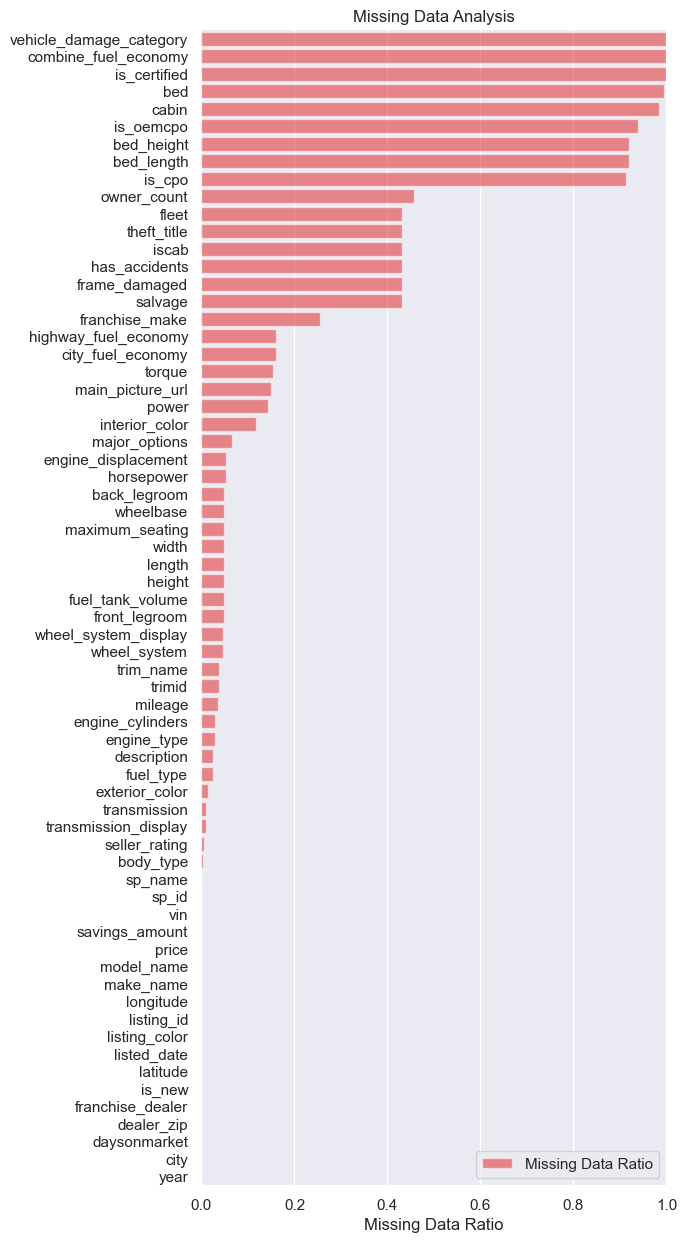

In [8]:
missing_ratios = cars_df.apply(lambda x: 1 - (x.count() / x.size))
missing_ratios = missing_ratios.sort_values(ascending=False)

plt.figure(figsize=(6, 15))
sns.set_theme()

sns.set_color_codes("pastel")
sns.barplot(x=missing_ratios, y=missing_ratios.index,
            label="Missing Data Ratio", color="red", alpha=0.5)

plt.legend(ncol=1, loc="lower right", frameon=True)
plt.xlim(0, 1)
plt.xlabel("Missing Data Ratio")
plt.ylabel("")
plt.title("Missing Data Analysis")
sns.despine(left=True, bottom=True)
plt.show()

Thanks to this graph, we were able to observe that numerous columns exhibit a significant number of missing values.

**The following columns will be discarded as they have more than 70% null values:**

In [9]:
nullsPercent = cars_df.apply(lambda x: 1 - (x.count() / x.size))
columnsnulls = nullsPercent[nullsPercent > 0.7].index
print(columnsnulls)

Index(['bed', 'bed_height', 'bed_length', 'cabin', 'combine_fuel_economy',
       'is_certified', 'is_cpo', 'is_oemcpo', 'vehicle_damage_category'],
      dtype='object')


## Column Analysis: Selecting Key Features for Analysis

In the process of choosing the key features for our analysis, we must consider two primary objectives: building a predictive model for vehicle prices and creating an efficient data warehouse.

____________________
**price**


Price of each vehicle. The main focus of this project revolves around predicting the price of each vehicle. 

In [10]:
cars_df['price'].sample(5)

20922    12900.0
98894    28621.0
93406    23885.0
32565    73995.0
10535    32500.0
Name: price, dtype: float64

In [11]:
cars_df['price'].describe()

count    1.000020e+05
mean     3.049937e+04
std      2.091560e+04
min      7.950000e+02
25%      1.799500e+04
50%      2.699500e+04
75%      3.872075e+04
max      1.390000e+06
Name: price, dtype: float64

**Checking the car price range**

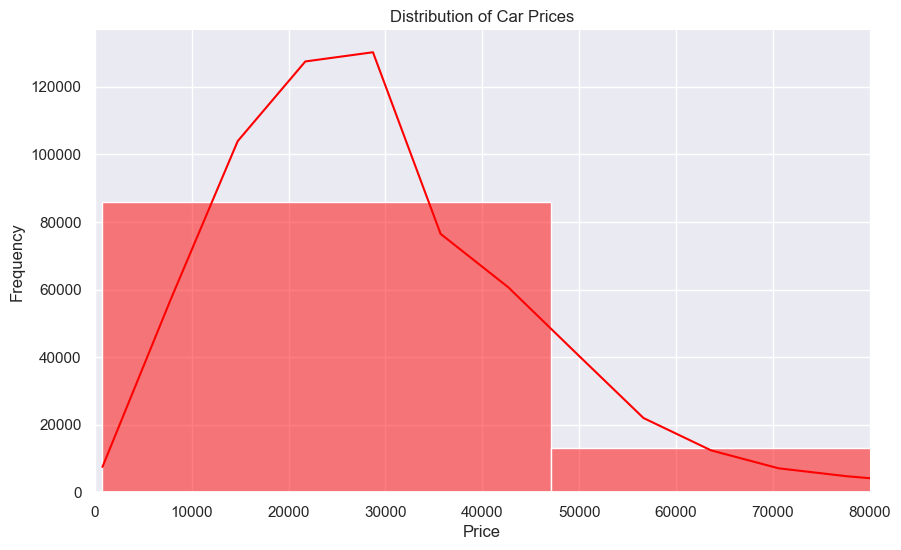

In [12]:
plt.figure(figsize=(10, 6))
sns.set_theme()
sns.histplot(data=cars_df, x='price', bins=30, kde=True, color="red", alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices')
plt.xlim(0, 80000)
sns.despine()
plt.show()

In [13]:
null_percentage_price = (cars_df['price'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'price' column is: {null_percentage_price:.2f}%")

The percentage of null values in the 'price' column is: 0.00%


____________________
**vin**

The Vehicle Identification Number (VIN) is a unique code assigned to each individual vehicle. Due to its distinctiveness, the VIN serves as a suitable candidate for the primary key of our dataset.

In [14]:
cars_df['vin'].sample(5)

97628    W1KZF8EB0LA832117
65248    WP1BA2AY4LDA47999
40403    1FMSK8DH6LGC39688
75734    WBSAE0C02LCD42128
72904    1C4RJFCG4HC712215
Name: vin, dtype: object

In [15]:
vin_unique_counts = cars_df['vin'].nunique()
print(f"Number of unique VINs: {vin_unique_counts}")

Number of unique VINs: 100000


The count of unique values in the `vin` column is lower than the total number of rows in the DataFrame, indicating the presence of duplicate data entries in the `vin` column.

____________________
**back_legroom / front_legroom / maximum_seating**

`Back_legroom` measures rear seat legroom with a standardized 40-inch front legroom. `Front_legroom` indicates legroom for front passengers under the same condition. `Maximum_seating` reveals the vehicle's comfortable passenger capacity.

In [16]:
cars_df[['back_legroom','front_legroom','maximum_seating']].sample(5)

,back_legroom,front_legroom,maximum_seating
25753,35.1 in,44.5 in,5 seats
69357,35.1 in,41.2 in,5 seats
52287,43.6 in,43.9 in,6 seats
39119,34.6 in,45.3 in,6 seats
55798,36.9 in,41.3 in,8 seats


These variables offer valuable insights into passenger space and capacity. For our analysis, we will focus primarily on the number of seats, as it is the most indicative among the three. Consequently, we will exclude the columns for front and back legroom.

In [17]:
null_percentage = (cars_df['maximum_seating'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'maximum_seating' column is: {null_percentage:.2f}%")

The percentage of null values in the 'maximum_seating' column is: 4.95%


Considering the relatively high percentage of null values (5.31%) in the `maximum_seating` column, it might be practical to impute a standard value, as individually reviewing each vehicle would not be efficient.

In [18]:
cars_df['maximum_seating'].unique()

array(['5 seats', '7 seats', '4 seats', '15 seats', '2 seats', '8 seats',
       nan, '6 seats', '3 seats', '--', '9 seats', '12 seats', '10 seats'],
      dtype=object)

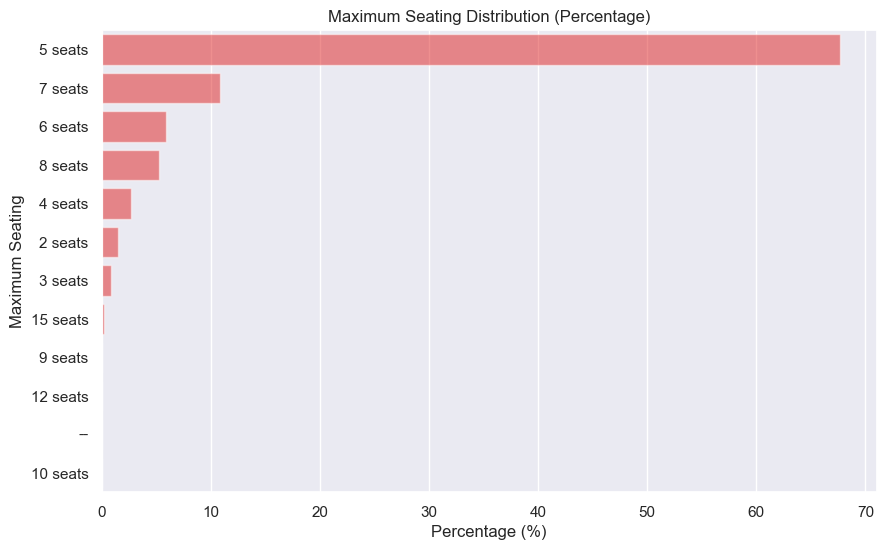

In [19]:
seating_percentage = cars_df['maximum_seating'].value_counts() / cars_df.shape[0] * 100
sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=seating_percentage.values, y=seating_percentage.index, orient='h', color='red', alpha=0.5)
plt.xlabel('Percentage (%)')
plt.ylabel('Maximum Seating')
plt.title('Maximum Seating Distribution (Percentage)')
plt.show()

Additionally, a transformation is required to extract the numerical value and remove the 'seat' text, facilitating further analysis.

____________________
**body_type**

Type of the vehicle.This information can be relevant in predicting the vehicle's price, as different body types often have different price ranges based on factors like market demand and manufacturing costs. 


In [20]:
cars_df['body_type'].sample(5)

29859    SUV / Crossover
92354              Sedan
15596              Sedan
91455          Hatchback
77019    SUV / Crossover
Name: body_type, dtype: object

In [21]:
body_types = cars_df['body_type'].unique()
print(f"Unique body types:\n{body_types}")

Unique body types:
['Pickup Truck' 'Sedan' 'SUV / Crossover' 'Wagon' 'Coupe' 'Van' 'Minivan'
 'Hatchback' 'Convertible' nan]


There are a total of 9 unique body types in the `body_type` column. The 'nan' value represents missing or unknown body types for certain vehicles in the dataset.

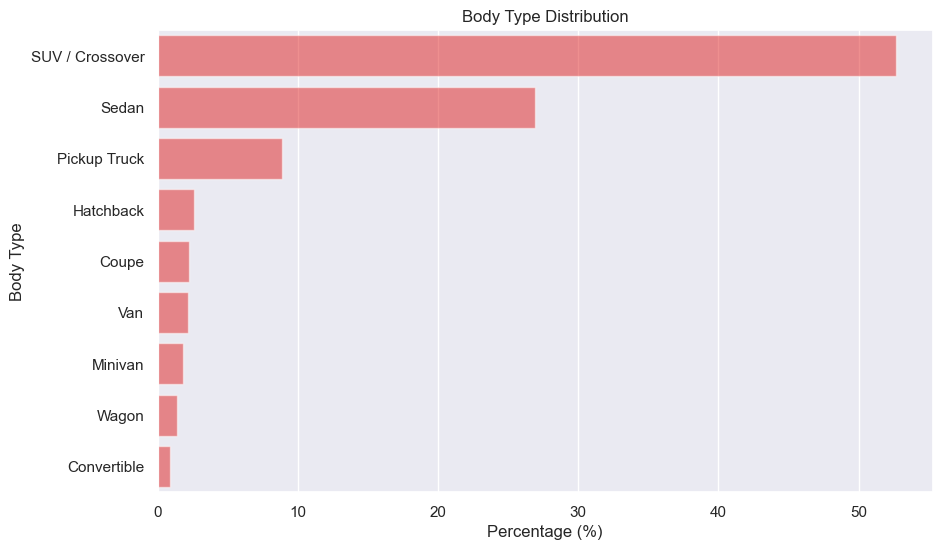

In [22]:
body_type_distribution = (cars_df['body_type'].value_counts() / len(cars_df)) * 100
sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=body_type_distribution.values, y=body_type_distribution.index, orient='h', color='red', alpha=0.5)
plt.xlabel('Percentage (%)')
plt.ylabel('Body Type')
plt.title('Body Type Distribution')
plt.show()

In [23]:
null_percentage = (cars_df['body_type'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'body_type' column is: {null_percentage:.2f}%")

The percentage of null values in the 'body_type' column is: 0.40%


With only 0.45% of null values in the `body_type` column, there are two main strategies to consider. Firstly, given the low proportion, removing rows with missing `body_type` values could be a straightforward approach, as these instances might not significantly impact the overall analysis. On the other hand, an alternative approach involves investigating the car models associated with the missing `body_type` values and assigning the most appropriate body type based on the model's characteristics.

________________________________________
**description**

Vehicle description on the listing page.

In [24]:
cars_df['description'].sample(5)

83460    Recent Arrival!   AWD. 4D Sport Utility 2017 H...
95122    2019 Dodge Grand Caravan SXT *1 Owner Carfax* ...
17544    VISIT WWW.PROJECTONEAUTO.COM TO VIEW MORE PICT...
4004     High Value Options  Back-Up Camera  Bluetooth ...
50573    [!@@Additional Info@@!]Turbocharged,Front Whee...
Name: description, dtype: object

The `description` column may contain additional details about the vehicle. However, this information is usually already available in other numerical and categorical columns. Since the information in the 'description' column can be subjective and redundant for our price prediction objectives, we have decided to exclude this column from our analysis.

____________________
**engine_type / engine_cylinder**

These two columns, `engine_type` and `engine_cylinder`, both provide information about the engine configuration of the vehicles.

In [25]:
cars_df[['engine_type','engine_cylinders']].sample(5)

,engine_type,engine_cylinders
4574,I4,I4
94247,I4,I4
51457,V6,V6
77662,V6,V6
68131,V6 Flex Fuel Vehicle,V6 Flex Fuel Vehicle


In [26]:
cars_df['engine_type'].equals(cars_df['engine_cylinders'])

True

Upon verification, we confirmed that the `engine_type` and `engine_cylinders` columns share identical information, confirming redundancy. 
In order to streamline our dataset and eliminate redundant information, we have opted to remove the `engine_cylinders` column.

In [27]:
null_percentage = (cars_df['engine_type'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'engine_type' column is: {null_percentage:.2f}%")

The percentage of null values in the 'engine_type' column is: 3.00%


In [28]:
engine_types = cars_df['engine_type'].unique()
print(f"Unique engine types:\n{engine_types}")

Unique engine types:
['V6' 'I6' 'V8' 'I4' 'I4 Hybrid' 'V6 Flex Fuel Vehicle' nan 'H4' 'I5'
 'V8 Flex Fuel Vehicle' 'I3' 'V8 Biodiesel' 'I6 Diesel'
 'I4 Flex Fuel Vehicle' 'I4 Diesel' 'V6 Hybrid' 'V8 Diesel' 'R2' 'W12'
 'V10' 'V12' 'V6 Biodiesel' 'V6 Diesel' 'H6' 'I2' 'W12 Flex Fuel Vehicle'
 'I5 Biodiesel' 'V8 Hybrid' 'H4 Hybrid' 'V8 Compressed Natural Gas']


During our examination of the unique engine types within the `engine_type` column, we've identified an intriguing connection between engine configuration and fuel type. Notably, certain engine types are commonly associated with specific fuel descriptors such as 'Diesel', 'Flex Fuel Vehicle', 'Biodiesel', and 'Compressed Natural Gas'. 
While this initial observation suggests a potential correlation, it is essential to delve further to avoid redundancy in our dataset.

____________________
**city_fuel_economy / highway_fuel_economy**

The columns `city_fuel_economy` and `highway_fuel_economy` provide information about a vehicle's fuel efficiency in city and highway traffic, respectively, measured in kilometers per liter.

In [29]:
cars_df[['city_fuel_economy','highway_fuel_economy']].sample(5)

,city_fuel_economy,highway_fuel_economy
44831,21.0,27.0
81648,NaN,NaN
34546,21.0,27.0
14923,22.0,31.0
95065,25.0,32.0


Not using `city_fuel_economy` and `highway_fuel_economy` is justified because they have many missing values (16.38%) and there are better alternative variables for the analysis. Imputing missing values might introduce inaccuracies and complexity.

____________________
**interior_color / exterior_color / listing_color**

These three columns capture essential aspects of a vehicle's color attributes. `Interior_color` reflects the interior's aesthetic appeal, `exterior_color` showcases the dominant outer hue, and interior_color further contributes to the overall visual harmony. 

In [30]:
cars_df[['interior_color','exterior_color','listing_color']].sample(5)

,interior_color,exterior_color,listing_color
42467,Blue (Sepia),Blueprint,UNKNOWN
54184,Black,White,WHITE
85432,Black,Shadow Gray Metallic,GRAY
11501,NaN,NaN,UNKNOWN
48901,Black,Diamond Black Crystal Pearlcoat,BLACK


In [31]:
unique_exterior_colors = len(list(cars_df['exterior_color'].unique()))
print(f"There are {unique_exterior_colors} unique values in the 'exterior_color' column.")

There are 4297 unique values in the 'exterior_color' column.


In [32]:
listing_colors = cars_df['listing_color'].unique()
print(f"Unique listing_colors:\n{listing_colors}")

Unique listing_colors:
['BLACK' 'BLUE' 'UNKNOWN' 'GRAY' 'WHITE' 'SILVER' 'GREEN' 'RED' 'ORANGE'
 'GOLD' 'BROWN' 'TEAL' 'PURPLE' 'YELLOW' 'PINK']


A transformation to standardize the `listing_color` column, ensuring values are not in all uppercase, is planned for future data enhancements.

The `listing_color` column effectively categorizes exterior colors, rendering it a useful choice. However, due to the extensive color variations, the `interior_color` column may not carry substantial relevance and can be excluded to manage dimensionality.

____________________
**franchise_make / make_name**

These two columns likely contain related information regarding the vehicle manufacturers. `franchise_make` denotes the company that owns the franchise, while `make_name` provides the name of the manufacturer. This variable could be relevant for predicting the vehicle's price, as different manufacturers might have varying brand reputations, market positioning, and overall desirability, which can influence pricing decisions.

In [33]:
cars_df[['franchise_make','make_name']].sample(5)

,franchise_make,make_name
52393,Dodge,Jeep
25873,Mercedes-Benz,Mercedes-Benz
87945,Ford,Ford
63655,Buick,Buick
59973,Mercedes-Benz,Mercedes-Benz


The column `franchise_make` has been removed due to redundancy with the `make_name` column. Despite not being identical, both columns contained similar information related to vehicle manufacturers.

In [34]:
make_names = cars_df['make_name'].unique()
print(f"Unique make names:\n{make_names}")

Unique make names:
['Chevrolet' 'BMW' 'Mercedes-Benz' 'Kia' 'Dodge' 'Jeep' 'Ford' 'Nissan'
 'Toyota' 'Lexus' 'Honda' 'Chrysler' 'Porsche' 'Volkswagen' 'Cadillac'
 'Mazda' 'Hyundai' 'INFINITI' 'Volvo' 'Acura' 'Subaru' 'Scion' 'Mercury'
 'RAM' 'Jaguar' 'Land Rover' 'Lincoln' 'Audi' 'Saab' 'Mitsubishi' 'Buick'
 'Maserati' 'MINI' 'GMC' 'Ferrari' 'Genesis' 'Saturn' 'FIAT' 'Bentley'
 'Suzuki' 'Tesla' 'Fisker' 'Pontiac' 'Lamborghini' 'Alfa Romeo' 'smart'
 'Hummer' 'Rolls-Royce' 'Lotus' 'Spyker' 'McLaren' 'Aston Martin' 'Kaiser'
 'Oldsmobile' 'Maybach' 'Freightliner' 'Karma' 'Isuzu' 'Plymouth']


Given the extensive variety of distinct manufacturer names and the absence of missing values, it's important to explore methods for reducing categories. Doing so could lead to more efficient analysis and visualization efforts.

In [35]:
null_percentage = (cars_df['make_name'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'make_name' column is: {null_percentage:.2f}%")

The percentage of null values in the 'make_name' column is: 0.00%


____________________
**model_name**

Represents the specific model name or designation of each vehicle.

In [36]:
cars_df['model_name'].sample(5)

92813      Escape
14201          ES
8388       Tiguan
47370      F-PACE
54818    Santa Fe
Name: model_name, dtype: object

In [37]:
model_name = cars_df['model_name'].nunique()
print(f"Number of unique model names: {model_name}")

Number of unique model names: 843


In [38]:
null_percentage = (cars_df['model_name'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'model_name' column is: {null_percentage:.2f}%")

The percentage of null values in the 'model_name' column is: 0.00%


Considering there are 1,429 unique model names in the dataset and no missing values, it's crucial to explore methods for categorically reducing these model names. 

____________________
**franchise_dealer**


Whether the dealer is a franchise dealer.


In [39]:
cars_df['franchise_dealer'].sample(5)

42220     True
30872     True
22371    False
16024     True
42520     True
Name: franchise_dealer, dtype: bool


We will not be using the `franchise_dealer` column as it does not hold significant relevance for our analysis and price prediction model.

____________________
**fuel_type**

Represents the dominant type of fuel used by the vehicle, such as gasoline, diesel, electric, etc. This attribute can be crucial in predicting the vehicle's price since different fuel types can affect operating costs, environmental factors, and overall market demand. 

In [40]:
cars_df['fuel_type'].sample(5)

10623    Gasoline
35053      Hybrid
66987    Gasoline
6863     Gasoline
96607    Gasoline
Name: fuel_type, dtype: object

In [41]:
fuel_types = cars_df['fuel_type'].unique()
print(f"Unique fuel types:\n{fuel_types}")

Unique fuel types:
['Gasoline' 'Hybrid' 'Flex Fuel Vehicle' nan 'Electric' 'Biodiesel'
 'Diesel' 'Compressed Natural Gas']


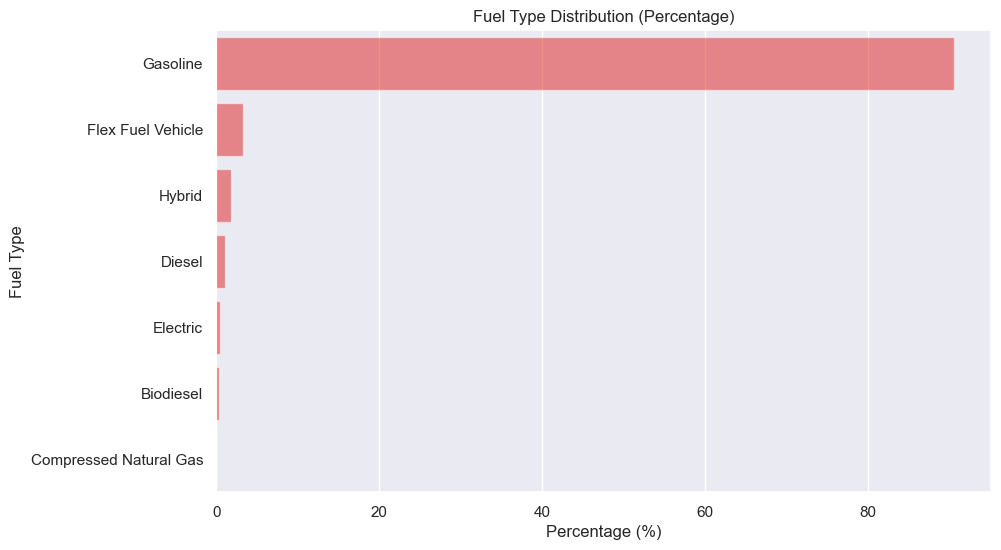

In [42]:
fuel_type_percentage = cars_df['fuel_type'].value_counts() / cars_df.shape[0] * 100
sns.set_theme()
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=fuel_type_percentage.values, y=fuel_type_percentage.index, orient='h', color='red', alpha=0.5)
plt.xlabel('Percentage (%)')
plt.ylabel('Fuel Type')
plt.title('Fuel Type Distribution (Percentage)')
plt.show()

In [43]:
null_percentage_fuel_type = (cars_df['fuel_type'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'fuel_type' column is: {null_percentage_fuel_type:.2f}%")

The percentage of null values in the 'fuel_type' column is: 2.46%


It's worth investigating whether these missing values correspond to a specific category that hasn't been accounted for, potentially through car model information. 

____________________
**fuel_tank_volume**

This column indicates the vehicle's fuel tank capacity in gallons, a relevant factor for fuel efficiency and pricing.
 

In [44]:
cars_df['fuel_tank_volume'].sample(5)

32374    15.9 gal
79419    18.5 gal
3223     21.1 gal
71356    24.5 gal
12365    24.6 gal
Name: fuel_tank_volume, dtype: object

However, it has been decided not to include this variable in the analysis as it is not deemed essential for the research objectives. Additionally, the variable will not be utilized in future transformations, as it is not considered a critical component for the prediction model.

____________________
**length / width / height**

The `length` column represents the vehicle's size in terms of length, measured in inches. Similarly, the `width` column indicates the width of the vehicle, also measured in inches. Lastly, the `height` column provides the height measurement of the vehicle in inches. 

In [45]:
cars_df[['length','width','height']].sample(5)

,length,width,height
95536,189.8 in,84.8 in,69.3 in
20614,189.7 in,84.1 in,72.8 in
76164,198.8 in,89.3 in,69.9 in
71190,180.9 in,73 in,67 in
26068,193.8 in,73 in,57.6 in


In [46]:
missing_percentage_length = cars_df['length'].isnull().mean() * 100
print(f"Percentage of missing values in 'length': {missing_percentage_length:.2f}%")

missing_percentage_width = cars_df['width'].isnull().mean() * 100
print(f"Percentage of missing values in 'width': {missing_percentage_width:.2f}%")

missing_percentage_height = cars_df['height'].isnull().mean() * 100
print(f"Percentage of missing values in 'height': {missing_percentage_height:.2f}%")

Percentage of missing values in 'length': 4.95%
Percentage of missing values in 'width': 4.95%
Percentage of missing values in 'height': 4.95%


However, as all three columns share the same 5.31% missing values, it is deemed redundant to use them for size estimation, given that the `body_type` variable already provides a good indication of the vehicle's size.

____________________
**horsepower / power**

The `horsepower` and `power` columns both convey information about the engine's power output, measured in horsepower units.This attribute can significantly influence a vehicle's price, as higher power output often correlates with enhanced performance and market value.

In [47]:
cars_df[['horsepower','power']].sample(5)

,horsepower,power
72155,355.0,"355 hp @ 5,600 RPM"
33526,170.0,"170 hp @ 5,600 RPM"
73080,219.0,NaN
10183,265.0,"265 hp @ 6,250 RPM"
75731,170.0,NaN


After evaluating the three variables, it has been determined that only the `horsepower` column will be used for our analysis, as it provides a comprehensive measure of engine performance. The `power` column will not be included in our analysis.

In [48]:
percentage = cars_df['horsepower'].isna().sum()/cars_df.shape[0]*100
print(f"The amount of null values in the horsepower column are {percentage.round(2)}%.")

The amount of null values in the horsepower column are 5.34%.


For the null values in the `horsepower column`, we'll assign the most common value within the typical range of 180 to 200 horsepower for mainstream cars.

____________________
**torque**


Measures the rotational force generated by the engine, crucial for describing engine performance.

In [49]:
cars_df['torque'].sample(5)

37199    300 lb-ft @ 1,300 RPM
16245    258 lb-ft @ 1,450 RPM
17758    260 lb-ft @ 4,000 RPM
4655     178 lb-ft @ 4,000 RPM
8889     295 lb-ft @ 2,200 RPM
Name: torque, dtype: object

While the `torque` column originally contained torque measurements in pound-feet (lb-ft) followed by engine revolutions per minute (RPM), it was planned to simplify the format for future analysis. However, the complexity in understanding this variable poses a challenge for the model, and considering the availability of other variables such as `horsepower`, it has been decided not to use 'torque' in the analysis.

____________________
**engine_displacement**


Measure of the cylinder volume swept by all pistons in a piston engine.

In [50]:
cars_df['engine_displacement'].sample(5)

21863    2000.0
33980    2000.0
28338    2000.0
49023    2000.0
27552    2400.0
Name: engine_displacement, dtype: float64

The `engine_displacement` column, which measures engine size, is redundant as similar information is available in other columns like `horsepower` and `torque`. To streamline our analysis, we have decided to drop this column.

______________
**main_picture_url**

URL of the main vehicle picture.

In [51]:
cars_df['main_picture_url'].sample(5)

7589     https://static.cargurus.com/images/forsale/202...
20403    https://static.cargurus.com/images/forsale/202...
6149     https://static.cargurus.com/images/forsale/202...
43249    https://static.cargurus.com/images/forsale/202...
72853    https://static.cargurus.com/images/forsale/202...
Name: main_picture_url, dtype: object

The `main_picture_url` column provides links to the main pictures of the vehicles. However, since our focus is on building a price prediction model, this column is not relevant for our analysis.

____________________
**city / dealer_zip / longitude / latitude**

The `city` column denotes the listing location of the car, offering valuable insights into regional market trends. The `dealer_zip` field comprises the dealership's zip code, contributing to geographical identification. Moreover, the `longitude` and `latitude` values furnish accurate geographic coordinates of the dealership's position, enhancing spatial understanding and convenience for potential buyers.

In [52]:
cars_df[['city','dealer_zip','longitude', 'latitude']].sample(5)

,city,dealer_zip,longitude,latitude
96065,Nashua,3063,-71.5005,42.7806
96806,Westwood,2090,-71.1818,42.2151
88571,Lowell,1851,-71.3218,42.6129
41043,Verona,7044,-74.2311,40.8253
96787,Nashua,3063,-71.5005,42.7806


For regional analysis, we are retaining the `dealer_zip` and `city columns`. The `dealer_zip` column is numeric, allowing us to infer the state where the vehicle is located based on zip codes. Therefore, having `longitude` and `latitude` columns would introduce redundancy since our primary focus is on regional insights derived from zip code and city data. 

________________
**major_options**

Insights into the significant features and notable choices associated with each vehicle.

In [53]:
cars_df['major_options'].sample(5)

34507    ['Alloy Wheels', 'Bluetooth', 'Remote Start', ...
89606    ['Sunroof/Moonroof', 'Navigation System', 'All...
15640    ['Leather Seats', 'Alloy Wheels', 'Third Row S...
75438    ['Popular Equipment Package', 'Navigation Syst...
35170    ['Alloy Wheels', 'Bluetooth', 'Backup Camera',...
Name: major_options, dtype: object

The `major_options` column contains arrays that list various options available for the vehicles. While this information could be relevant, our approach will be to first examine the array with the longest list of options and identify the categories present. We'll then assess if these categories are consistently repeated across other rows.

In [54]:
max_length = 0  
max_index = -1  

for i in range(len(cars_df)):
    options = cars_df.loc[i, 'major_options']
   
    if pd.notna(options):
        options_list = str(options).replace("[", "").replace("]", "").replace("'", "").split(', ')
        length = len(options_list)
        
        if length > max_length:
            max_length = length
            max_index = i
            
print(cars_df.loc[max_index, 'major_options'],max_length)

['Leather Seats', 'Sunroof/Moonroof', 'Navigation System', 'Adaptive Cruise Control', 'Premium Wheels', 'Blind Spot Monitoring', 'Parking Sensors', 'Heated Seats', 'Premium Package', 'Tow Package', 'Cold Weather Package', 'Multi Zone Climate Control', 'Luxury Package', 'Acoustical Package', 'Appearance Package', 'Audio Package', 'Bi Xenon Headlamp Package', 'Comfort Package', 'Convenience Package', 'Convenience Plus Package', 'Customer Preferred Package', 'Elite Package', 'Extra Value Package', 'Heat Package', 'Levant Package', 'Light Package', 'Memory Package', 'Multimedia Package', 'Off Road Package', 'Popular Equipment Package', 'Power Mirror Package', 'Power Package', 'Preferred Accessory Package', 'Preferred Equipment Package', 'Preferred Package', 'Premium Audio Package', 'Premium Sound Package', 'Rear Climate Package', 'Safety Package', 'SE Package', 'Security Package', 'Skid Plate Package', 'SL Package', 'Sound Package', 'Sport Package', 'Storage Package', 'Suspension Package',

Upon closer examination, we found that the `major_options` column, despite its array-like structure, was stored as a string. While reviewing the data, we discovered that the largest array consists of 59 distinct categories.

Creating numerous dummy variables for these categories could lead to a high-dimensional dataset, especially without confirming their consistent presence in other vehicles. Due to this complexity and potential redundancy, we've decided to remove the `major_options` column from our dataset during data preparation.

____________________
**year**

The `year` column represents the manufacturing year of the vehicle. This information can significantly influence the vehicle's price, as newer vehicles tend to have higher values due to advanced features, improved technology, and overall desirability in the market.

In [55]:
cars_df['year'].sample(5)

76103    2020
17860    2019
23714    2020
29012    2021
15395    2017
Name: year, dtype: int64

In [56]:
null_percentage = (cars_df['year'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'year' column is: {null_percentage:.2f}%")

The percentage of null values in the 'year' column is: 0.00%


**Analysis of Relationship between Year and Price of Used Vehicles**

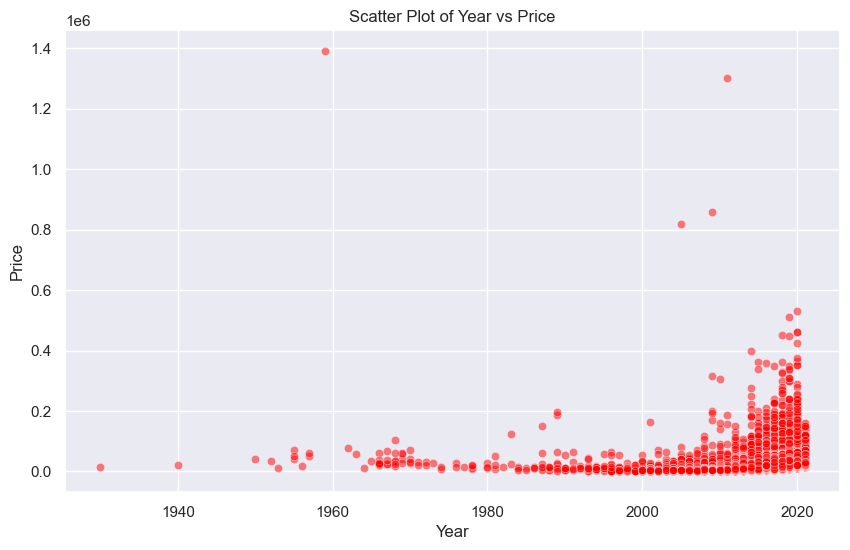

In [57]:
sns.set_theme()

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x="year", y="price", data=cars_df, color="red", alpha=0.5)
scatter_plot.set_xlabel("Year")
scatter_plot.set_ylabel("Price")
scatter_plot.set_title("Scatter Plot of Year vs Price")

plt.show()

In [58]:
correlation = cars_df["year"].corr(cars_df["price"])
print(f"Correlation between Year and Price: {correlation:.2f}")

Correlation between Year and Price: 0.41


The correlation between the `Year` and `Price` variables is 0.36. This positive correlation suggests that there is a moderate tendency for newer vehicles to have higher prices.

____________________
**mileage**

Indicates the cumulative distance covered by the vehicle, shedding light on its historical usage and wear. This attribute significantly influences the vehicle's pricing, with higher mileage typically correlating to lower prices due to increased wear and tear over time.

In [59]:
cars_df['mileage'].sample(5)

39937         2.0
53291         3.0
98753        16.0
66953    155745.0
47724     31050.0
Name: mileage, dtype: float64

In [60]:
null_percentage_mileage = (cars_df['mileage'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'mileage' column is: {null_percentage_mileage:.2f}%")

The percentage of null values in the 'mileage' column is: 3.56%


The `mileage` column has a notable percentage of missing values, accounting for 4.81% of the dataset. To address this, it's important to investigate whether the absence of data indicates new vehicles or whether using the mean value of this column could be a suitable approach.

**Analysis of Relationship between Mileage and Price of Used Vehicles**

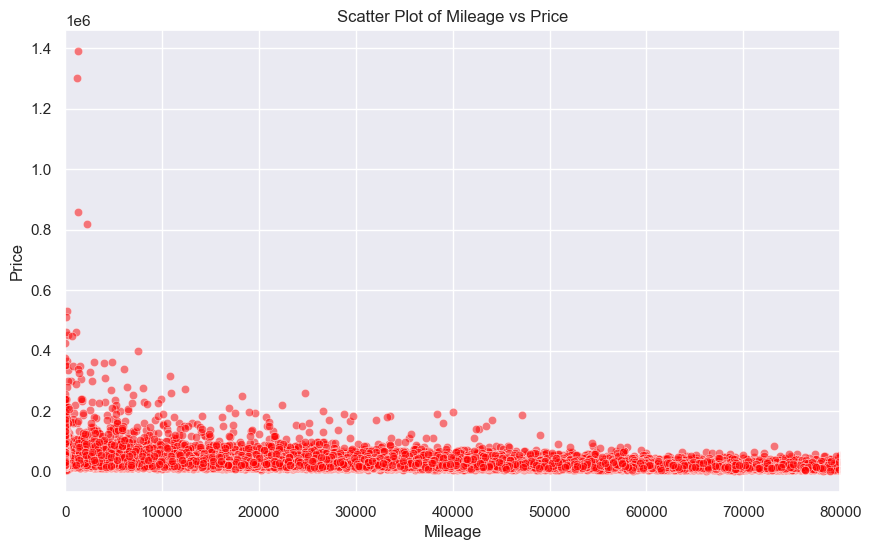

In [61]:
sns.set_theme()

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x="mileage", y="price", data=cars_df, color="red", alpha=0.5)
scatter_plot.set_xlabel("Mileage")
scatter_plot.set_ylabel("Price")
scatter_plot.set_title("Scatter Plot of Mileage vs Price")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 80000)

plt.show()

In [62]:
correlation_mileage = cars_df["mileage"].corr(cars_df["price"])
print(f"Correlation between Mileage and Price: {correlation_mileage:.2f}")

Correlation between Mileage and Price: -0.48


This negative correlation suggests that as the mileage of a vehicle increases, its price tends to decrease.

____________________
**is_new**

The `is_new` column is a categorical variable that indicates whether a vehicle was launched less than 2 years before 2020. This attribute helps to identify relatively new vehicles in the dataset.

In [63]:
cars_df['is_new'].sample(5)

32291    False
63307     True
39691     True
51259     True
73204     True
Name: is_new, dtype: bool

____________________
**isCab**

The `isCab` column is a categorical variable that indicates whether a vehicle was previously used as a taxi or cab. However, for our specific analysis and price prediction, we won't be utilizing this column as it doesn't significantly contribute to the prediction model's relevance or accuracy.

In [64]:
cars_df['iscab'].sample(5)

39607    false
42235      NaN
9255     false
12374    false
23998    false
Name: iscab, dtype: object

____________________
**fleet / theft_title / has_accidents / frame_damaged / salvage**

The `fleet` column indicates whether the vehicle was previously part of a fleet, while `theft_title` signifies a title indicating theft history. `has_accidents` denotes if any accidents are registered for the vehicle, and `frame_damaged` indicates whether the vehicle has a damaged frame. Lastly, `salvage` provides information about a salvage title.

In [65]:
cars_df[['has_accidents', 'salvage', 'frame_damaged', 'theft_title', 'fleet']].sample(5)

,has_accidents,salvage,frame_damaged,theft_title,fleet
89406,false,false,false,false,false
92799,NaN,NaN,NaN,NaN,NaN
67090,false,false,false,false,false
55057,NaN,NaN,NaN,NaN,NaN
44867,false,false,false,false,false


In [66]:
columns_to_check = ['has_accidents', 'salvage', 'frame_damaged', 'theft_title', 'fleet']

for column in columns_to_check:
    percentage = cars_df[column].isna().sum() / cars_df.shape[0] * 100
    print(f"The percentage of null values in the '{column}' column is: {percentage:.2f}%.")


The percentage of null values in the 'has_accidents' column is: 43.08%.
The percentage of null values in the 'salvage' column is: 43.08%.
The percentage of null values in the 'frame_damaged' column is: 43.08%.
The percentage of null values in the 'theft_title' column is: 43.08%.
The percentage of null values in the 'fleet' column is: 43.08%.


These columns contain a significant number of missing values, making up approximately 47.55% of the null values in the dataset. However, we will solely focus on the `frame_damaged` column for our analysis, as it has the potential to impact vehicle prices. The other columns, will not be utilized in our price prediction model due to their limited relevance.

____________________
**listing_id / listed_date / daysonmarket**


These columns, related to website data, are crucial for our analysis. `Listing_id` uniquely identifies each vehicle, `listed_date` tracks listing trends, and `daysonmarket` shows how long listings stay active, impacting pricing.

In [67]:
cars_df[['listing_id', 'listed_date', 'daysonmarket']].sample(5)

,listing_id,listed_date,daysonmarket
50605,279765479,2020-08-20,20
58216,245725177,2019-07-07,430
63349,234106083,2019-03-07,552
73957,277908722,2020-07-30,41
26331,281632162,2020-09-09,0


In [68]:
unique_listing_ids = cars_df['listing_id'].nunique()
print(f"Number of unique listing IDs: {unique_listing_ids}")

Number of unique listing IDs: 100000


`Listing_id` which uniquely identifies each vehicle, was initially considered; however, it has been decided not to use it as the `vin` of the vehicle is available and serves the same purpose

____________________
**owner_count**

The `owner_count` column represents the number of previous owners a used vehicle has had. This attribute provides insights into the vehicle's ownership history and can be useful for assessing its overall condition and potential value in the used car market.


In [69]:
cars_df['owner_count'].sample(5)

38603    1.0
37243    1.0
27011    NaN
43771    NaN
6627     3.0
Name: owner_count, dtype: float64

In [70]:
null_percentage = (cars_df['owner_count'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'owner_count' column is: {null_percentage:.2f}%")

The percentage of null values in the 'owner_count' column is: 45.72%


Due to the high number of null values in the `owner_count` column, it's essential to find a solution to handle these missing values effectively. One potential approach is to replace these nulls with a placeholder value, like '-1,' indicating that the number of previous owners is unknown.

____________________
**wheel_system / wheel_system_display / wheelbase**

These columns contain information related to the vehicle's wheel system and wheelbase. 

In [71]:
cars_df[['wheel_system', 'wheel_system_display', 'wheelbase']].sample(5)

,wheel_system,wheel_system_display,wheelbase
62709,AWD,All-Wheel Drive,104.7 in
5541,AWD,All-Wheel Drive,106.7 in
98198,AWD,All-Wheel Drive,113.1 in
74623,AWD,All-Wheel Drive,99.2 in
55325,FWD,Front-Wheel Drive,107.3 in


The `wheelbase` column has been excluded from the analysis, and the `wheel_system` column is being dropped due to redundancy in our analysis."




In [72]:
wheel_system_values = cars_df['wheel_system_display'].unique()
print(f"Unique values in 'wheel_system' column:\n{wheel_system_values}")

Unique values in 'wheel_system' column:
['Four-Wheel Drive' 'Rear-Wheel Drive' 'Front-Wheel Drive'
 'All-Wheel Drive' nan '4X2']


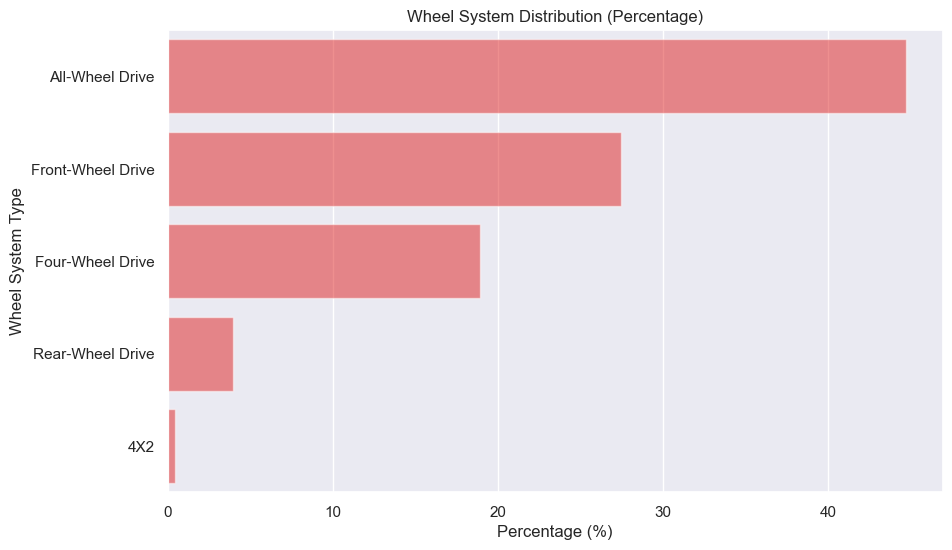

In [73]:
wheel_system_percentage = cars_df['wheel_system_display'].value_counts() / cars_df.shape[0] * 100
sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=wheel_system_percentage.values, y=wheel_system_percentage.index, orient='h', color='red', alpha=0.5)
plt.xlabel('Percentage (%)')
plt.ylabel('Wheel System Type')
plt.title('Wheel System Distribution (Percentage)')
plt.show()

____________________
**transmission / transmission_display**


The `transmission` and `transmission_display` columns both provide information about the transmission type of vehicles.

In [74]:
cars_df[['transmission_display', 'transmission']].sample(5)

,transmission_display,transmission
3836,Automatic,A
96424,Automatic,A
7146,Automatic,A
33238,Continuously Variable Transmission,CVT
2011,6-Speed Automatic,A


In [75]:
transmission_display_values = cars_df['transmission_display'].unique()
print(f"Unique values in 'transmission_display' column:\n{transmission_display_values}")

Unique values in 'transmission_display' column:
['8-Speed Automatic' '5-Speed Automatic' '6-Speed Automatic'
 '7-Speed Automatic' 'Automatic' '6-Speed Dual Clutch'
 '6-Speed Automatic Overdrive' '4-Speed Automatic'
 'Continuously Variable Transmission' '6-Speed Manual' '9-Speed Automatic'
 '5-Speed Manual' '1-Speed Automatic' nan '9-Speed Automatic Overdrive'
 'Manual' '2-Speed Automatic' '7-Speed Dual Clutch'
 '6-Speed Manual Overdrive' '5-Speed Automatic Overdrive' '7-Speed CVT'
 '4-Speed Automatic Overdrive' '8-Speed Automatic Overdrive' '6-Speed CVT'
 '8-Speed Manual' '7-Speed Automatic Overdrive' '8-Speed Dual Clutch'
 '8-Speed CVT' '5-Speed Manual Overdrive' '3-Speed Manual'
 '3-Speed Automatic' '4-Speed Manual' '7-Speed Manual'
 '10-Speed Automatic' '1-Speed Dual Clutch' '1-Speed CVT']


In [76]:
transmission_values = cars_df['transmission'].unique()
print(f"Unique values in 'transmission' column:\n{transmission_values}")

Unique values in 'transmission' column:
['A' 'Dual Clutch' 'CVT' 'M' nan]


We'll primarily use the `transmission` column for a simplified representation of transmission types, better suited for our analysis. The `transmission_display` column contains more detailed information, but we'll focus on the broader categories in `transmission` and drop `transmission_display`.

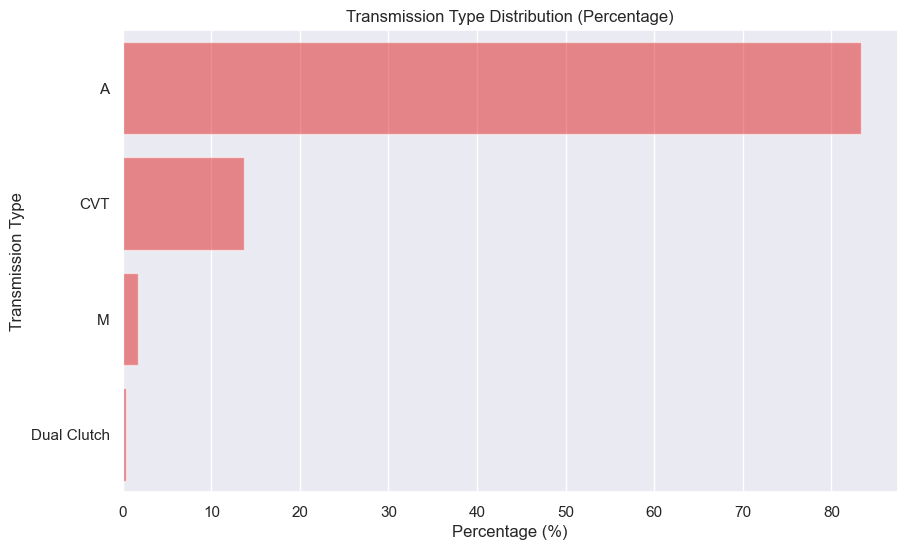

In [77]:
transmission_counts = cars_df['transmission'].value_counts() / cars_df.shape[0] * 100
sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=transmission_counts.values, y=transmission_counts.index, orient='h', color='red', alpha=0.5)
plt.xlabel('Percentage (%)')
plt.ylabel('Transmission Type')
plt.title('Transmission Type Distribution (Percentage)')
plt.show()

In [78]:
null_percentage = cars_df['transmission'].isnull().sum() / len(cars_df)* 100
print(f"The percentage of null values in the 'transmission' column is: {null_percentage:.2f}%")

The percentage of null values in the 'transmission' column is: 1.00%


Certainly, given that there are only a few null values in the `transmission` column, we can reasonably replace these missing values with the most common transmission type.

____________________
**trimId / trim_name**


The `trimId` and `trim_name` columns serve as unique identifiers and labels for different vehicle trims or configurations. 

In [79]:
cars_df[['trimid', 'trim_name']].sample(5)

,trimid,trim_name
92996,t67808,LT Double Cab 4WD
5215,NaN,NaN
64216,t83745,EX FWD
37644,t41719,1.6 S
92311,t85859,Limited FWD


While these columns may be useful for specific identification purposes, they do not significantly contribute to our analysis or price prediction model. 

____________________
**sp_id / sp_name**


The `sp_id` column stores service principal IDs, which are unique identifiers used for specific commands related to service providers. On the other hand, the `sp_name` column contains the names of the dealerships selling the vehicles.

In [80]:
cars_df[['sp_id', 'sp_name']].sample(5)

,sp_id,sp_name
74778,402954,AutoMax Preowned Attleboro
34291,398629,Bell Ford
46859,274070,George Wall Ford
45065,392079,Fox Toyota Volkswagen of Rochester Hills
95047,273753,Newport Chrysler Dodge Jeep Ram


We will investigate the meaningful connection between `sp_name` and `sp_id` by counting unique `sp_name` values for each `sp_id`. 


In [81]:
unique = cars_df['sp_name'].nunique()
print(f"Unique values in 'sp_name': {unique}")
unique = cars_df['sp_id'].nunique()
print(f"Unique values in 'sp_id': {unique}")

Unique values in 'sp_name': 858
Unique values in 'sp_id': 859


However, for our data warehouse, we will retain only the `sp_name` variable, as we can create unique identifiers if necessary for each name.

___________________
**seller_rating**


The `seller_rating` column represents the rating of the dealership selling the vehicle, typically measured on a scale of 1 to 5 stars. This rating provides an indicator of the dealership's reputation and can be valuable for assessing the trustworthiness and quality of the seller.

In [82]:
cars_df['seller_rating'].sample(5)

11835    3.888889
41223    4.692308
49423    4.200000
6461     3.312500
19443    4.500000
Name: seller_rating, dtype: float64

In [83]:
unique_seller_ratings = cars_df['seller_rating'].nunique()
print(f"The number of unique values in the 'seller_rating' column is: {unique_seller_ratings}")

The number of unique values in the 'seller_rating' column is: 406


Considering the `seller_rating` column's extensive range of 1817 unique values, we recognize the need to categorize these ratings into broader groups, simplifying the analysis. One potential approach is to use the integer part of the ratings; for example, '2.2' would become '2'.

In [84]:
null_percentage = cars_df['seller_rating'].isnull().sum() / len(cars_df) * 100
print(f"The percentage of null values in the 'seller_rating' column is: {null_percentage:.2f}%")

The percentage of null values in the 'seller_rating' column is: 0.64%


As for the limited number of null values, around 1.36%, we have the option to either safely eliminate them due to their small quantity or assign them the lowest possible rating, which could be 0.

___________________
**savings_amount**


The `savings_amount` column represents the amount of money saved compared to the original price of the vehicle. 

In [85]:
cars_df['savings_amount'].sample(5)

86777       0
89890       0
27205       0
75043       0
60105    3407
Name: savings_amount, dtype: int64

In [86]:
null_percentage = (cars_df['savings_amount'].isnull().sum() / len(cars_df)) * 100
print(f"The percentage of null values in the 'savings_amount' column is: {null_percentage:.2f}%")

The percentage of null values in the 'savings_amount' column is: 0.00%


The primary reason is that this variable might not be directly related to predicting the vehicle's price and could introduce noise or complexity into the model. Instead, the focus will be on other variables more directly linked to the price prediction task

### Columns to Drop due to High Null Values:
- `bed`
- `bed_height`
- `bed_length`
- `cabin`
- `combine_fuel_economy`
- `is_certified`
- `is_cpo`
- `is_oemcpo`
- `vehicle_damage_category`

### Columns to Drop due to Redundancy:
- `engine_cylinder`
- `exterior_color`
- `franchise_make`
- `transmission_display`
- `wheel_system`

### Columns with Other Explanatory Variables:
- `back_legroom`
- `city_fuel_economy`
- `engine_displacement`
- `front_legroom`
- `fuel_tank_volume`
- `height`
- `highway_fuel_economy`
- `latitude`
- `length`
- `longitude`
- `power`
- `torque`
- `wheelbase`
- `width`

### Non-Relevant Columns:
- `description`
- `fleet`
- `franchise_dealer`
- `has_accidents`
- `interior_color`
- `isCab`
- `listing_id`
- `major_options`
- `main_picture_url`
- `salvage`
- `savings_amount`
- `sp_id`
- `theft_title`
- `trimId`
- `trim_name`


In [87]:
columns_to_drop = [
    'bed', 'bed_height', 'bed_length', 'cabin', 'combine_fuel_economy',
    'is_certified', 'is_cpo', 'is_oemcpo', 'vehicle_damage_category',
    'engine_cylinders', 'exterior_color', 'franchise_make', 'wheel_system',
    'transmission_display', 'latitude', 'longitude', 'back_legroom',
    'front_legroom', 'power', 'has_accidents', 'salvage', 'theft_title',
    'fleet', 'engine_displacement', 'description', 'interior_color',
    'franchise_dealer', 'main_picture_url', 'major_options', 'iscab',
    'trimid', 'trim_name', 'city_fuel_economy', 'highway_fuel_economy',
    'length', 'height', 'width', 'torque', 'wheelbase', 'fuel_tank_volume',
    'savings_amount', 'sp_id', 'listing_id'
]

cars_df.drop(columns=columns_to_drop, inplace=True)

In [88]:
cars_df.drop_duplicates(inplace=True)

In [89]:
cars_df.shape

(100000, 23)

A total of 43 columns and 40 rows have been successfully removed from the dataset, resulting in a reduced dataset containing 23 columns. These retained columns include: `vin`, `body_type`, `city`, `daysonmarket`, `dealer_zip`, `engine_type`, `frame_damaged`, `fuel_type`, `horsepower`, `is_new`, `listed_date`, `listing_color`, `make_name`, `maximum_seating`, `mileage`, `model_name`, `owner_count`, `price`, `seller_rating`, `sp_name`, `transmission`, `wheel_system_display`, and `year`.


## Data Transformation

**Handling Outliers**

____________________
**price**

<Axes: >

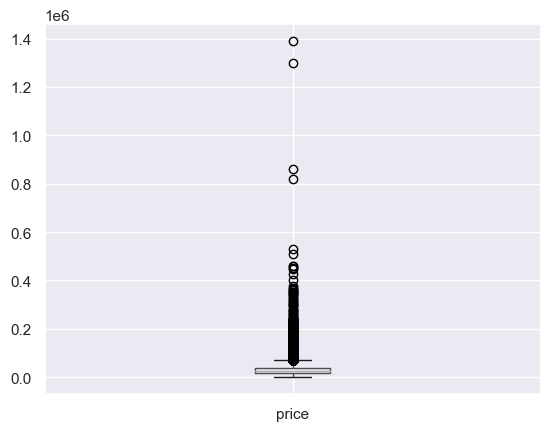

In [90]:
cars_df.boxplot(column='price')

In the boxplot, it is evident that there are numerous outliers, highlighting the need for their identification and subsequent removal to maintain data quality and integrity.

In [91]:
cars_df_copy = cars_df.copy()

In [92]:
mean_price = cars_df_copy['price'].mean()
std_price = cars_df_copy['price'].std()
threshold = 2 * std_price
outliers = cars_df[(cars_df['price'] < (mean_price - threshold)) | (cars_df['price'] > (mean_price + threshold))]
print(f"Number of outliers: {len(outliers)}")
cars_df_copy = cars_df_copy[(cars_df_copy['price'] >= (mean_price - threshold)) & (cars_df_copy['price'] <= (mean_price + threshold))]
cars_df_copy['price'] = cars_df_copy['price'].astype(int)
cars_df_copy['price'].sample(3)

Number of outliers: 2859


63214    24495
61025     7988
31397    21300
Name: price, dtype: int32

After identifying and eliminating 2,859 outliers in the `price` variable using a threshold of 2 times the standard deviation, the format of the `price` column was changed to an integer.

____________________
**mileage**

In [93]:
mean_mileage = cars_df_copy['mileage'].mean()
std_mileage = cars_df_copy['mileage'].std()
threshold = 2 * std_mileage
outliers = cars_df_copy[(cars_df_copy['mileage'] < (mean_mileage - threshold)) | (cars_df_copy['mileage'] > (mean_mileage + threshold))]
print(f"Number of outliers: {len(outliers)}")
cars_df_copy = cars_df_copy[(cars_df_copy['mileage'] >= (mean_mileage - threshold)) & (cars_df_copy['mileage'] <= (mean_mileage + threshold))]
cars_df_copy['mileage'].fillna(mean_mileage, inplace=True)
cars_df_copy['mileage'] = cars_df_copy['mileage'].astype(int)
cars_df_copy['mileage'].sample(3)

Number of outliers: 5892


56533    115602
80233     87832
71541        30
Name: mileage, dtype: int32

Similarly, in the `mileage` column, 5892 outliers were identified and removed using the same standard deviation method. Additionally, to handle missing values, NaN values in the `mileage` column were filled with the column's mean, and the `mileage` format was changed to an integer.

**Missing Values: Removing Nulls**

____________________
**body_type**

In [94]:
cars_df_copy['body_type'].value_counts(dropna=False)

body_type
SUV / Crossover    46342
Sedan              24340
Pickup Truck        7583
Hatchback           2316
Van                 1769
Coupe               1715
Minivan             1474
Wagon               1205
Convertible          695
NaN                  318
Name: count, dtype: int64

In [95]:
cars_df_copy = cars_df_copy[pd.notna(cars_df_copy['body_type'])]
cars_df_copy['body_type'].unique()

array(['Pickup Truck', 'Sedan', 'SUV / Crossover', 'Wagon', 'Coupe',
       'Van', 'Minivan', 'Convertible', 'Hatchback'], dtype=object)

Given the small number of missing values in the `body_type`column, it was decided to simply remove them.

____________________
**fuel_type**

In [96]:
cars_df_copy = cars_df_copy[pd.notna(cars_df_copy['fuel_type'])]
cars_df_copy['fuel_type'].unique()

array(['Gasoline', 'Hybrid', 'Flex Fuel Vehicle', 'Electric', 'Biodiesel',
       'Diesel', 'Compressed Natural Gas'], dtype=object)

The decision to remove the null values in the  `fuel_type` column was made because this information was essential for populating the `engine_type` column. Without knowledge of the fuel type, it wouldn't provide significant relevance.

**Transformations**

____________________
**engine_type**

In [97]:
cars_df_copy['engine_type'] = cars_df_copy['engine_type'].str.split(' ').str[0]

In [98]:
nan_engine_type = cars_df_copy[pd.isna(cars_df_copy['engine_type'])]
nan_engine_type[['engine_type','fuel_type']].value_counts(dropna=False)

engine_type  fuel_type
NaN          Electric     384
             Diesel        49
             Gasoline       5
Name: count, dtype: int64

In [99]:
cars_df_copy.loc[pd.isna(cars_df_copy['engine_type']) & (cars_df_copy['fuel_type'] == "Electric"), 'engine_type'] = "Electric"
cars_df_copy.loc[pd.isna(cars_df_copy['engine_type']) & (cars_df_copy['fuel_type'] == "Diesel"), 'engine_type'] = "Diesel"
cars_df_copy.loc[pd.isna(cars_df_copy['engine_type']) & (cars_df_copy['fuel_type'] == "Gasoline"), 'engine_type'] = "Gasoline"
cars_df_copy.loc[pd.isna(cars_df_copy['engine_type']) & (cars_df_copy['fuel_type'] == "Gasoline"), 'engine_type'] = "Gasoline"
cars_df_copy['engine_type'].unique()

array(['V6', 'I6', 'V8', 'I4', 'H4', 'Electric', 'I3', 'I5', 'R2',
       'Diesel', 'W12', 'H6', 'I2', 'V10', 'Gasoline', 'V12'],
      dtype=object)

Given the strong relationship between `engine_type` and `fuel_type` (e.g., 'V8 Diesel'), it was decided to retain only the engine type information and remove the fuel type. Where `engine_type` was missing (NaN), it was assigned the value from `fuel_type`, considering that many of these missing values corresponded to electric, diesel, or gasoline cars.

_______________
**transmission**

In [100]:
cars_df_copy['transmission'].value_counts()

transmission
A              70614
CVT            12490
M               1365
Dual Clutch      311
Name: count, dtype: int64

In [101]:
cars_df_copy['transmission'].fillna('A', inplace=True)
cars_df_copy['transmission'] = cars_df_copy['transmission'].replace({
        'A': 'Automatic', 
        'CVT': 'Continuously Variable Transmission', 
        'M': 'Manual'
})
cars_df_copy['transmission'].unique()

array(['Automatic', 'Dual Clutch', 'Continuously Variable Transmission',
       'Manual'], dtype=object)

In general, the transformations in the  `transmission` column involved addressing missing values by replacing them with the most common category, 'Automatic' (represented as 'A'). Additionally, category labels were updated to provide clearer and more informative descriptions.

_______________
**listing_color**

In [102]:
cars_df_copy['listing_color'] = cars_df_copy['listing_color'].str.capitalize()
cars_df_copy['listing_color'].unique()

array(['Black', 'Blue', 'Unknown', 'Gray', 'White', 'Silver', 'Green',
       'Orange', 'Red', 'Brown', 'Purple', 'Gold', 'Teal', 'Yellow',
       'Pink'], dtype=object)

The format of the  `listing_color` column was modified to capitalize the first letter of each word, providing a more standardized and visually appealing format.

_______________
**horsepower**

In [103]:
cars_df_copy['horsepower'] = cars_df_copy['horsepower'].apply(lambda x: random.uniform(180, 200) if pd.isna(x) else x).astype(int)
cars_df_copy['horsepower'].sample(5)

50130    370
49702    187
96596    170
35970    272
63989    252
Name: horsepower, dtype: int32

To address missing values in the `horsepower`column, a decision was made to randomly assign values between 180 and 200. This range was chosen to reflect the average horsepower of a new car, which typically falls within this range. 

_____________________
**maximum_seating**

In [104]:
result = cars_df_copy.groupby('body_type')['maximum_seating'].agg(lambda x: x.mode().iloc[0])
result

body_type
Convertible        4 seats
Coupe              4 seats
Hatchback          5 seats
Minivan            8 seats
Pickup Truck       6 seats
SUV / Crossover    5 seats
Sedan              5 seats
Van                2 seats
Wagon              5 seats
Name: maximum_seating, dtype: object

In [105]:
cars_df_copy['maximum_seating'].replace(["--"], np.nan, inplace=True)
filtered_df = cars_df_copy[pd.isna(cars_df_copy['maximum_seating'])]
body_types_with_nan = filtered_df['body_type'].unique()
body_types_with_nan

array(['SUV / Crossover', 'Pickup Truck', 'Sedan', 'Coupe', 'Hatchback',
       'Van', 'Wagon', 'Minivan', 'Convertible'], dtype=object)

In [106]:
default_seating_values = {'Convertible': '4', 'Coupe': '4', 'Hatchback': '5', 'Minivan': '8', 'Pickup Truck': '6', 'SUV / Crossover': '5', 'Sedan': '5', 'Van': '2', 'Wagon': '5'}
cars_df_copy['maximum_seating'] = cars_df_copy.apply(lambda row: default_seating_values.get(row['body_type'], str(row['maximum_seating']).replace(" seats", "")) if pd.isna(row['maximum_seating']) else str(row['maximum_seating']).replace(" seats", ""), axis=1).astype(int)
cars_df_copy['maximum_seating'].unique()

array([ 5,  4, 15,  2,  7,  8,  6,  3, 12, 10,  9])

To address missing values in the `maximum_seating` column, the most common value (mode) for `maximum_seating` was assigned based on the `body_type` group. Additionally, ' seats' was removed from the string, and the values were converted to integers to ensure consistent data format.

___________________
**seller_rating**

In [107]:
cars_df_copy['seller_rating'] = cars_df_copy['seller_rating'].apply(np.ceil).fillna(0).astype(int)
cars_df_copy['seller_rating'].unique()

array([4, 5, 1, 3, 0, 2])

To simplify the `seller_rating` column, only the integer part of the rating was retained. Any missing values were assigned a reputation score of 0. The entire `seller_rating` column was subsequently converted to integers.

____________________
**owner_count**

In [108]:
cars_df_copy['owner_count'] = cars_df_copy['owner_count'].fillna(-1).astype(int)
cars_df_copy['owner_count'].unique()

array([ 1,  2, -1,  5,  4,  3,  6,  7,  9,  8, 10, 12, 15])

To address missing values in the `owner_count` column, an identifier of -1 was used to indicate cases where the number of owners is unknown. This approach was chosen to retain the data while acknowledging the absence of owner count information.

__________________
**frame_damaged**

In [109]:
cars_df_copy['frame_damaged'] = cars_df_copy['frame_damaged'].fillna('false').replace({'false': 0, 'true': 1})
cars_df_copy['frame_damaged'].unique()

array([0, 1], dtype=int64)

To handle missing values in the `frame_damaged` column, any null values were replaced with 0 indicating that no frame damage was reported. After this transformation, the `frame_damaged` column now only contains either 1 or 0 values.

__________________
**is_new**

In [110]:
cars_df_copy['is_new'] = cars_df_copy['is_new'].replace({False: 0, True: 1})
cars_df_copy['is_new'].unique()

array([0, 1], dtype=int64)

For convenience, the `is_new` column was transformed by replacing True with 1 and False with 0.


_______________
**dealer_zip**

In [111]:
def get_state(zip_code, engine, zip_dict):
    if zip_code in zip_dict:
        return zip_dict[zip_code]
    try:
        zipcode = engine.by_zipcode(zip_code)
        state = zipcode.state_long
        zip_dict[zip_code] = state
        return state
    except:
        return np.nan

In [112]:
engine = SearchEngine()
zip_dict = {}
cars_df_copy['dealer_state'] = cars_df_copy['dealer_zip'].apply(lambda x: get_state(x, engine, zip_dict))
cars_df_copy['dealer_state'].unique()

array(['New York', 'New Jersey', 'Connecticut', 'Michigan',
       'Massachusetts', 'Ohio', 'Illinois', 'Pennsylvania', 'Kentucky',
       'Rhode Island', 'Indiana', 'Texas', 'Nebraska', 'New Hampshire',
       'Vermont', 'Maine', 'Puerto Rico'], dtype=object)

A new column, `dealer_state` was created to hold the state information obtained from the `dealer_zip` column, providing additional location details for the dataset. This transformation was carried out to enhance the dataset with geographic information.

**Data Transformation Summary**

In [113]:
cars_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85549 entries, 0 to 100001
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   vin                   85549 non-null  object        
 1   body_type             85549 non-null  object        
 2   city                  85549 non-null  object        
 3   daysonmarket          85549 non-null  int64         
 4   dealer_zip            85549 non-null  int64         
 5   engine_type           85549 non-null  object        
 6   frame_damaged         85549 non-null  int64         
 7   fuel_type             85549 non-null  object        
 8   horsepower            85549 non-null  int32         
 9   is_new                85549 non-null  int64         
 10  listed_date           85549 non-null  datetime64[ns]
 11  listing_color         85549 non-null  object        
 12  make_name             85549 non-null  object        
 13  maximum_seating     

After completing all the necessary transformations, the dataset no longer contains any missing or null values. The dataset is now clean and ready for further analysis and is prepared for storage.

## Data Warehouse Design

**Date Dimension**

In [114]:
def create_date_dimension(df):
    date_df = df[['listed_date']].copy()
    date_df['listed_date'] = pd.to_datetime(date_df['listed_date'])
    date_df = date_df.drop_duplicates().reset_index(drop=True)
    date_df['date_key'] = date_df['listed_date'].dt.strftime('%Y%m%d')
    date_df['year'] = date_df['listed_date'].dt.year
    date_df['short_month'] = date_df['listed_date'].dt.strftime('%b')
    date_df['day_of_week'] = date_df['listed_date'].dt.strftime('%A')
    date_df['listed_date'] = date_df['listed_date'].dt.strftime('%Y-%m-%d')
    date_df.rename(columns={'listed_date': 'date'}, inplace=True)
    date_df = date_df[['date_key', 'date', 'short_month', 'day_of_week','year']]
    return date_df

In [115]:
date_df = create_date_dimension(cars_df_copy)
date_df.head()

,date_key,date,short_month,day_of_week,year
0,20200729,2020-07-29,Jul,Wednesday,2020
1,20200830,2020-08-30,Aug,Sunday,2020
2,20200829,2020-08-29,Aug,Saturday,2020
3,20200901,2020-09-01,Sep,Tuesday,2020
4,20200320,2020-03-20,Mar,Friday,2020


In [116]:
cars_df_copy['date_key'] = cars_df_copy['listed_date'].dt.strftime('%Y%m%d')
cars_df_copy['date_key'].nunique()

797

The Date Dimension is designed to capture and organize information related to dates. It plays a critical role in time-based analysis and reporting.

**Model Dimension**

In [117]:
def create_model_dimension(df):
    model_df = df[['make_name', 'model_name', 'body_type']].copy()
    model_df = model_df.drop_duplicates().reset_index(drop=True)
    model_df['full_model_name'] = model_df['make_name'] + ' ' + model_df['model_name']
    model_df['model_key'] = model_df.index
    model_df = model_df[['model_key', 'make_name', 'model_name', 'full_model_name','body_type']]
    return model_df

In [118]:
model_df = create_model_dimension(cars_df_copy)
model_df.head()

,model_key,make_name,model_name,full_model_name,body_type
0,0,Chevrolet,Colorado,Chevrolet Colorado,Pickup Truck
1,1,BMW,3 Series,BMW 3 Series,Sedan
2,2,Mercedes-Benz,S-Class,Mercedes-Benz S-Class,Sedan
3,3,Chevrolet,Cruze,Chevrolet Cruze,Sedan
4,4,Kia,Soul,Kia Soul,SUV / Crossover


In [119]:
cars_df_copy = cars_df_copy.merge(model_df, on=['make_name', 'model_name', 'body_type'], how='left')
cars_df_copy['model_key'].nunique()

806

The Model Dimension contains detailed information about vehicle models and their characteristics, which is crucial for analyzing and reporting on vehicle-related data.

**Location Dimension**

In [120]:
def create_location_dimension(df):
    location_df = df[['city', 'dealer_state']].copy()
    location_df = location_df.drop_duplicates().reset_index(drop=True)
    location_df['location_key'] = location_df.index
    location_df['city_state'] = location_df['city'] + ', ' + location_df['dealer_state']
    location_df.rename(columns={'dealer_state': 'state'}, inplace=True)
    location_df = location_df[['location_key', 'city', 'state', 'city_state']]
    return location_df

In [121]:
location_df = create_location_dimension(cars_df_copy)
location_df .head()

,location_key,city,state,city_state
0,0,Bay Shore,New York,"Bay Shore, New York"
1,1,Little Ferry,New Jersey,"Little Ferry, New Jersey"
2,2,Bohemia,New York,"Bohemia, New York"
3,3,East Hartford,Connecticut,"East Hartford, Connecticut"
4,4,Danbury,Connecticut,"Danbury, Connecticut"


In [122]:
cars_df_copy = cars_df_copy.merge(location_df, left_on=['dealer_state','city'],right_on=['state','city'], how='left')
cars_df_copy['location_key'].nunique()

436

The Location Dimension is created to capture and organize data related to geographic locations, providing insights into regional variations within the dataset.

**Dealer Dimension**

In [123]:
def create_dealer_dimension(df):
    dealer_df = df[['seller_rating', 'sp_name']].copy()
    dealer_df = dealer_df.drop_duplicates().reset_index(drop=True)
    dealer_df = dealer_df.groupby('sp_name').agg({'seller_rating': 'max'}).reset_index()
    dealer_df['dealer_key'] = dealer_df.index
    dealer_df = dealer_df.rename(columns={
        'dealer_key': 'dealer_key',
        'seller_rating': 'reputation_score',
        'sp_name': 'dealer_name',
    })
    dealer_df= dealer_df[['dealer_key','dealer_name','reputation_score']]
    return dealer_df

In [124]:
dealer_df = create_dealer_dimension(cars_df_copy)
dealer_df.head()

,dealer_key,dealer_name,reputation_score
0,0,103 Auto Sales,5
1,1,112 Auto Plaza,5
2,2,1st Priority Autos,5
3,3,21st Century Auto Group,3
4,4,26 Motors,4


In [125]:
cars_df_copy = cars_df_copy.merge(dealer_df, left_on=['sp_name'],right_on=['dealer_name'], how='left')
cars_df_copy['dealer_key'].nunique()

845

The Dealer Dimension is designed to aggregate essential data pertaining to dealers, emphasizing their reputation scores and names. 

**Fact Table**

In [126]:
def create_fact_table(df):
    fact_table = df.drop(columns=[
        'reputation_score',
        'dealer_name',
        'city_state',
        'state',
        'full_model_name',
        'dealer_state',
        'sp_name',
        'seller_rating',
        'model_name',
        'listed_date',
        'city',
        'dealer_zip',
        'body_type',
        'make_name'   
    ])
    
    fact_table = fact_table.rename(columns={
        'vin': 'vehicle_vin',
        'daysonmarket': 'days_on_market',
        'engine_type': 'engine',
        'frame_damaged': 'has_accidents',  
        'listing_color': 'color', 
        'maximum_seating': 'seating_capacity',
        'transmission': 'transmission',
        'wheel_system_display': 'drivetrain',
        'year': 'vehicle_year',
    })

    return fact_table

In [127]:
fact_table = create_fact_table(cars_df_copy)
fact_table.head()

,vehicle_vin,days_on_market,engine,has_accidents,fuel_type,horsepower,is_new,color,seating_capacity,mileage,owner_count,price,transmission,drivetrain,vehicle_year,date_key,model_key,location_key,dealer_key
0,1GCGTCEN5H1236094,42,V6,0,Gasoline,308,0,Black,5,35222,1,30439,Automatic,Four-Wheel Drive,2017,20200729,0,0,46
1,WBA3A9C51CF270309,10,I6,0,Gasoline,300,0,Blue,5,97535,2,11999,Automatic,Rear-Wheel Drive,2012,20200830,1,1,495
2,WDBNG70J1YA076348,11,V8,0,Gasoline,275,0,Black,5,94949,1,4499,Automatic,Rear-Wheel Drive,2000,20200829,2,1,495
3,1G1BE5SM1H7138472,8,I4,0,Gasoline,153,0,Unknown,5,37979,1,14639,Automatic,Front-Wheel Drive,2017,20200901,3,0,46
4,KNDJ53AF1L7724866,173,I4,0,Gasoline,201,1,Black,5,12,-1,26075,Automatic,Front-Wheel Drive,2020,20200320,4,2,328


## Regression Model

The predictive model will be constructed using RandomForestRegressor to forecast the `price`.

**Selecting features**

The feature selection was limited to numeric variables, specifically focusing on `daysonmarket`, `horsepower`, `maximum_seating`, `mileage`, `seller_rating`, `year`, and `price`.

In [128]:
numeric_features = [
    "daysonmarket",
    "horsepower",
    "maximum_seating",
    "mileage",
    "seller_rating",
    "year",
    "price"
]

cars_analysis = cars_df_copy[numeric_features]
cars_analysis.head()

,daysonmarket,horsepower,maximum_seating,mileage,seller_rating,year,price
0,42,308,5,35222,4,2017,30439
1,10,300,5,97535,4,2012,11999
2,11,275,5,94949,4,2000,4499
3,8,153,5,37979,4,2017,14639
4,173,201,5,12,4,2020,26075


**Correlation Matrix**

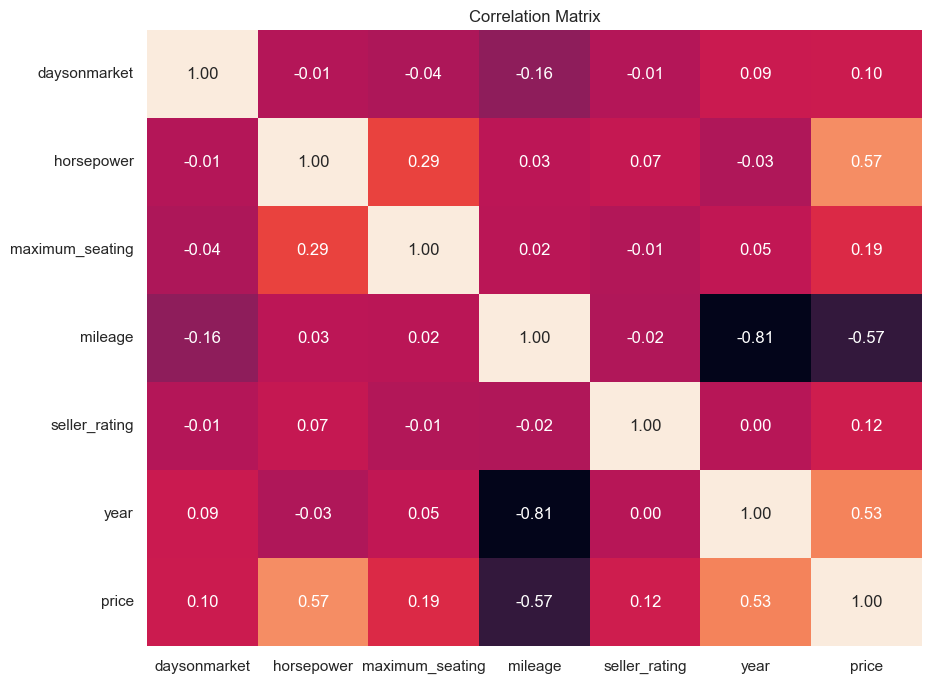

In [129]:
correlation_matrix = cars_analysis.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,fmt=".2f", cbar=False)
plt.title("Correlation Matrix")
plt.show()

In selecting variables for the model, consideration was given to their correlation with `price` favoring those with an absolute correlation greater than 0.5:

- 0.57 for `horsepower`
- 0.57 for `mileage`
- 0.53 for `year`

**Splitting the dataset**

In [137]:
y = cars_analysis["price"]
X = cars_analysis.drop(columns=["price","daysonmarket","seller_rating","maximum_seating"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

The dataset was split into training and testing sets, with 80% of the data used for training the model and the remaining 20% reserved for evaluating its performance. 

**Training the model**

In [138]:
regressor = RandomForestRegressor(n_estimators=100,
                                  random_state=0)

regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

**R-squared**

In [140]:
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2) Score: {r2}')

R-squared (R2) Score: 0.8235171788777729


The R-squared (R2) score of 0.823 indicates that approximately 82.35% of the variability in the price of cars can be explained by the model using the selected variables: horsepower, mileage, and year. 

In [141]:
df_forest = pd.DataFrame({'index': range(len(y_test)), 'price': y_test, 'prediction': y_pred})
df_forest

,index,price,prediction
67872,0,18944,19854.030000
40464,1,20995,23622.920000
48901,2,69975,53987.490000
13829,3,25995,31717.890000
50113,4,13699,14850.940000
...,...,...,...
68120,17105,22995,28097.468333
52453,17106,5800,5599.650000
12884,17107,30995,34350.080000
29510,17108,23178,27950.536538


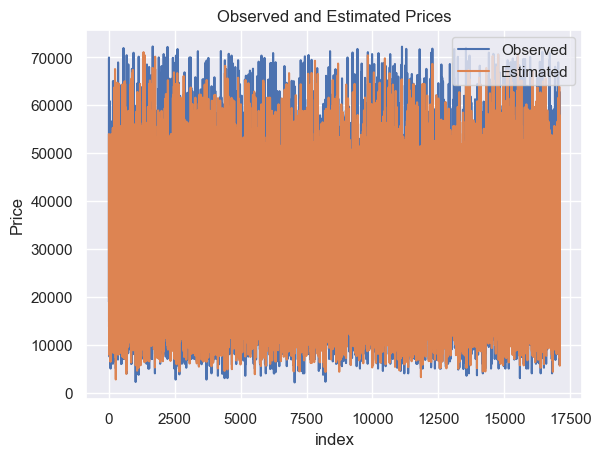

In [142]:
sns.set_theme()
sns.lineplot(x='index', y='price', data=df_forest, label='Observed')
sns.lineplot(x='index', y='prediction', data=df_forest, label='Estimated')
plt.ylabel('Price')
plt.title('Observed and Estimated Prices')
plt.legend()
plt.show()

Although the model tends to underestimate prices, its ability to remain within the observed range implies a reasonably accurate predictive performance. Notably, the model avoids generating negative values or values that surpass the observed ones.

**Saving trained model**

In [135]:
joblib_file = "../model/random_forest_regressor.pkl"
joblib.dump(regressor, joblib_file)

['../model/random_forest_regressor.pkl']